In [ ]:
import major_axis_features
import numpy as np
import polars as pl

In [14]:
rotation_data = pl.read_csv("../data/null_datasets/MT19937/rotation_data.csv")
moments = pl.read_csv("../data/null_datasets/MT19937/MT19937_region_props_moments.csv").with_columns(
    (pl.col('image').str.extract(r"rendition_(\d+_\w+)\.jpg").alias('KID_IDFrameKey')),
    (pl.col('image').str.extract(r"rendition_(\d+)_\w+\.jpg").cast(pl.Int64).alias('index'))
    ).sort(pl.col('index'))

In [15]:
full_set_of_data = rotation_data.join(moments, pl.col('KID_IDFrameKey'))
full_set_of_data = full_set_of_data.with_columns(
    pl.when(pl.col('orientation_degrees') < 0)
    .then(90.0 + pl.col('orientation_degrees'))
    .when((pl.col('orientation_degrees') > 0) & (pl.col('orientation_degrees') < 90))
    .then(90 - pl.col('orientation_degrees'))
    .otherwise(pl.col('orientation_degrees'))
    .alias('orientation_degrees_clamped')
    )

In [16]:
OBJECT_AXES = {
    "CribNovel": np.array([1,0,0]),
    "TrainNovel": np.array([1,0,0]),
    "HighChairNovel": np.array([0,0,1]),
    "CameraNovel": np.array([1,0,0])
}

In [ ]:
rotated_axes = []
for row in full_set_of_data.iter_rows(named=True):
    obj_axis = OBJECT_AXES[row['Object']]
    euler_x = row['Euler_X']
    euler_y = row['Euler_Y']
    euler_z = row['Euler_Z']
    rotated = major_axis_features.compute_main_axis_rotated(obj_axis, euler_x, euler_y, euler_z)
    rotated_axes.append(rotated)

angles_from_vert = []
for new_axis in rotated_axes:
    angle = major_axis_features.compute_angle_from_vertical_dot(new_axis)
    angles_from_vert.append(angle)

full_set_of_data = full_set_of_data.with_columns(pl.Series('angle_from_vert', angles_from_vert), pl.Series('rotated_axes', rotated_axes))

In [18]:
full_set_of_data

KID_IDFrameKey,Euler_X,Euler_Y,Euler_Z,Object,RNG_method,image,centroid_x,centroid_y,axis_major_length,axis_minor_length,axis_ratio_minor_to_major,orientation_radians,orientation_degrees,index,orientation_degrees_clamped,angle_from_vert,rotated_axes
str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,"array[f64, 3]"
"""0_CribNovel""",87.863166,-144.948675,10.190089,"""CribNovel""","""MT19937""","""rendition_0_CribNovel.jpg""",386.268066,272.767958,120.748773,74.16955,0.614247,-0.191784,-10.988401,0,79.011599,77.615983,"[-0.805725, 0.176914, 0.565251]"
"""1_TrainNovel""",140.052236,41.440223,-19.355123,"""TrainNovel""","""MT19937""","""rendition_1_TrainNovel.jpg""",370.039527,294.545777,125.35697,62.354905,0.497419,-0.59565,-34.128203,1,55.871797,64.892773,"[0.707279, -0.331422, -0.624433]"
"""2_HighChairNovel""",56.560485,-9.259449,-36.156956,"""HighChairNovel""","""MT19937""","""rendition_2_HighChairNovel.jpg""",417.674961,277.533915,154.466539,58.588839,0.379298,0.844787,48.402708,2,41.597292,40.458134,"[-0.574588, -0.673753, 0.464657]"
"""3_CameraNovel""",-142.98223,-113.747439,3.46979,"""CameraNovel""","""MT19937""","""rendition_3_CameraNovel.jpg""",406.185311,312.904697,72.249669,33.718356,0.466692,0.47933,27.463561,3,62.536439,81.437577,"[-0.401968, 0.060522, 0.913652]"
"""4_CribNovel""",-37.464636,-177.681807,35.579318,"""CribNovel""","""MT19937""","""rendition_4_CribNovel.jpg""",393.778463,292.357926,113.43238,99.884576,0.880565,-0.598898,-34.314353,4,55.685647,54.398481,"[-0.812645, 0.581829, 0.032898]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""995_CameraNovel""",-135.799983,68.282691,50.050621,"""CameraNovel""","""MT19937""","""rendition_995_CameraNovel.jpg""",392.070868,312.433376,70.906807,59.013502,0.832269,-1.498974,-85.884899,995,4.115101,17.219944,"[0.237599, 0.766612, -0.596534]"
"""996_CribNovel""",96.19606,-82.492125,-41.927212,"""CribNovel""","""MT19937""","""rendition_996_CribNovel.jpg""",382.008146,298.505678,118.355066,80.704614,0.681886,-1.462135,-83.774148,996,6.225852,8.277693,"[0.097212, -0.668186, 0.737616]"
"""997_TrainNovel""",163.872545,-1.222614,-24.435205,"""TrainNovel""","""MT19937""","""rendition_997_TrainNovel.jpg""",395.792027,299.851413,149.19966,54.586271,0.365861,-0.463532,-26.558423,997,63.441577,65.559882,"[0.910222, -0.413664, 0.019426]"


In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow, Ellipse
from matplotlib.lines import Line2D
from PIL import Image
import os
import numpy as np

# Create output directory if it doesn't exist
output_dir = "../data/null_datasets/MT19937/annotated_images"
os.makedirs(output_dir, exist_ok=True)

# List to store the saved image paths
saved_image_paths = []

# Create a single figure and reuse it
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, row in enumerate(full_set_of_data.iter_rows(named=True)):
    # Clear the previous plot
    ax.clear()
    
    # Load and display image
    img = Image.open(f"../data/null_datasets/MT19937/renditions/{row['image']}")
    ax.imshow(img)
    
    x = row['centroid_x']
    y = row['centroid_y']
    
    # Add arrow (red, thicker)
    dx = rotated_axes[i][0] * 100
    dy = rotated_axes[i][1] * -100
    arr_patch = FancyArrow(x, y, dx, dy, color='r', width=5, head_width=15, head_length=10)
    ax.add_patch(arr_patch)
    
    # Add ellipse (blue, thicker)
    ell_patch = Ellipse((x, y), 2*row['axis_major_length'], 2*row['axis_minor_length'], 
                        angle=-row['orientation_degrees'], fill=False, edgecolor='b', linewidth=3)
    ax.add_patch(ell_patch)
    
    # Add main axis line (yellow, thick, unit length)
    angle_rad = np.deg2rad(-row['orientation_degrees'])
    unit_length = 100  # Same scale as the arrow (100 pixels)
    
    # Calculate endpoints of unit-length major axis
    x1 = x - 0.5 * unit_length * np.cos(angle_rad)
    y1 = y - 0.5 * unit_length * np.sin(angle_rad)
    x2 = x + 0.5 * unit_length * np.cos(angle_rad)
    y2 = y + 0.5 * unit_length * np.sin(angle_rad)
    
    # Draw the major axis
    major_axis_line = Line2D([x1, x2], [y1, y2], color='g', linewidth=3)
    ax.add_line(major_axis_line)
    
    ax.set_title(row['image'])
    ax.axis('off')  # Optional: remove axes
    
    # Save the figure
    output_filename = f"annotated_{row['image']}"
    output_path = os.path.join(output_dir, output_filename)
    fig.savefig(output_path, bbox_inches='tight', dpi=150)
    
    # Store the path
    saved_image_paths.append(output_path)

# Close the figure after all iterations
plt.close(fig)

# Add the saved paths to the dataframe
combined_dataframe = full_set_of_data.with_columns(
    pl.Series("annotated_image_path", saved_image_paths + [None] * (len(full_set_of_data) - len(saved_image_paths)))
)

print(f"Saved {len(saved_image_paths)} annotated images to {output_dir}")

Saved 1000 annotated images to ../data/null_datasets/MT19937/annotated_images


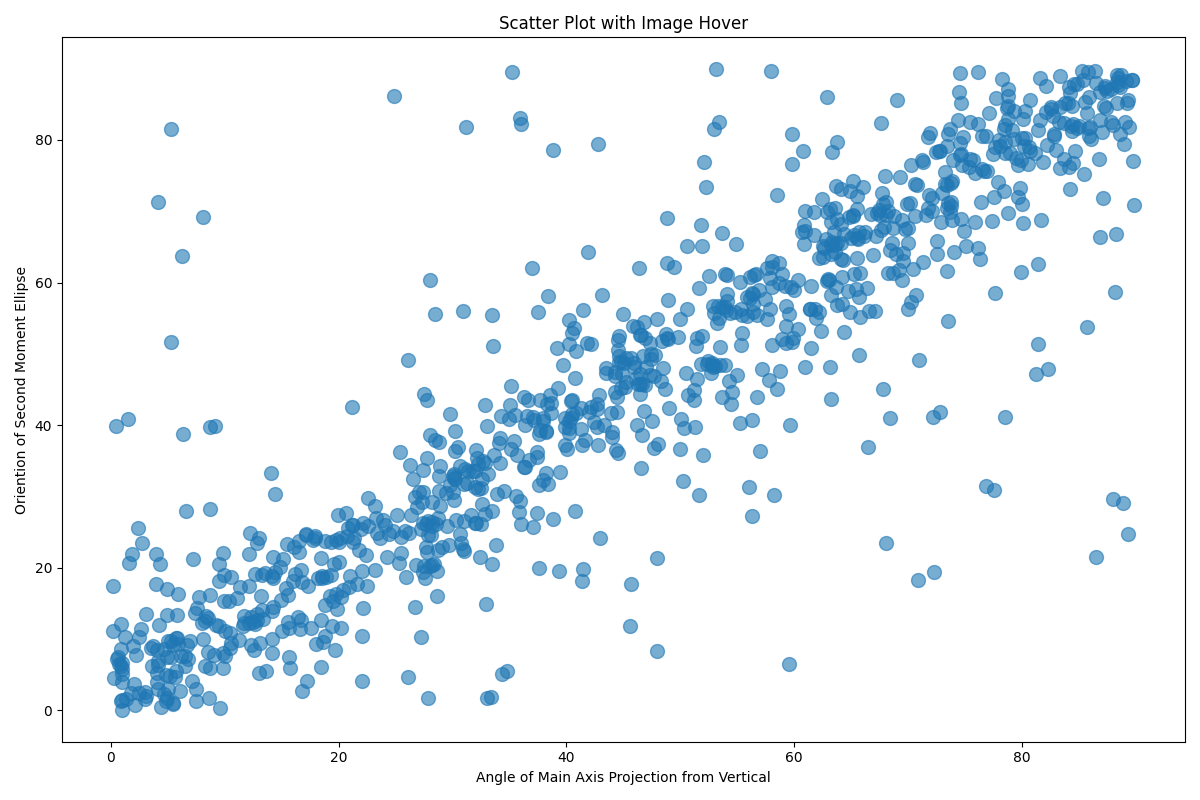

In [20]:
# Enable interactive mode for Jupyter
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np


# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create the scatter plot
scatter = ax.scatter(
    combined_dataframe['angle_from_vert'],
    combined_dataframe['orientation_degrees_clamped'],
    s=100,
    alpha=0.6
)

ax.set_xlabel('Angle of Main Axis Projection from Vertical')
ax.set_ylabel('Oriention of Second Moment Ellipse')
ax.set_title('Scatter Plot with Image Hover')

# Create an annotation box for the image (initially invisible)
imagebox = AnnotationBbox(
    OffsetImage(np.zeros((10, 10, 3)), zoom=1),
    (0, 0),
    frameon=True,
    pad=0.5,
    box_alignment=(0.5, -0.1),
    visible=False
)
ax.add_artist(imagebox)

# Text annotation for labels
annot = ax.annotate(
    "",
    xy=(0, 0),
    xytext=(10, 10),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9),
    fontsize=10,
    visible=False
)

def hover(event):
    if event.inaxes == ax:
        # Check if mouse is over a point
        cont, ind = scatter.contains(event)
        
        if cont:
            # Get the index of the point and convert to Python int
            idx = int(ind["ind"][0])
            
            # Get data for this point (Polars syntax)
            x = combined_dataframe['angle_from_vert'][idx]
            y = combined_dataframe['orientation_degrees_clamped'][idx]
            image_name = combined_dataframe['image'][idx]
            image_path = combined_dataframe['annotated_image_path'][idx]
            
            # Update text annotation
            text = f"{image_name}\nMajor Axis: {x:.2f}\nEllipse: {y:.2f}"
            annot.xy = (x, y)
            annot.set_text(text)
            annot.set_visible(True)
            
            # Load and display image
            try:
                img = Image.open(image_path)
                # Resize image if too large
                img.thumbnail((400, 400))
                
                # Update image box
                imagebox_new = OffsetImage(img, zoom=1)
                imagebox.offsetbox = imagebox_new
                imagebox.xy = (x, y)
                imagebox.set_visible(True)
            except Exception as e:
                print(f"Error loading image: {e}")
                imagebox.set_visible(False)
            
            fig.canvas.draw_idle()
        else:
            # Hide annotations when not hovering over points
            if annot.get_visible():
                annot.set_visible(False)
                imagebox.set_visible(False)
                fig.canvas.draw_idle()

# Connect the hover event
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.tight_layout()
plt.show()